# Basic model fitting in Python

A must-have tool in a scientific PhD student's toolbox is model fitting. This is a huge topic, with lots of different possible approaches, depending on the complexity (and quality) of the data and the model. We'll cover here very basic cases, but this can be the starting point for a much more thorough exploration.

## Simple 2D curve fitting with numpy

In simple cases with a small number of model parameters, a good approach (which ensures a good understanding of the results) is that of computing the likelihood function (or posterior probability) over a regular grid using `numpy`, then looking for the maximum likelihood / maximum posterior. This is really the preferred method for low-dimensional parameter spaces, as it allows for a complete view of the dependence of the goodness of fit on the parameters. 

As a practical example, let us consider life expectancy data in Italy since 1872. A simple table with comma-separated values is given in `lesson5/life-expectancy-italy.csv`. It looks like this:

In [1]:
data = open('../lesson5/life-expectancy-italy.csv','r')

for i in range(10):
    print(data.readline(),end='')

print('...')
data.close()

# life expectancy in Italy since 1872, from ourworldindata.org
Year,life_expectancy
1872,29.700001
1873,31.610001
1874,31.76
1875,31.33
1876,33.619999
1877,34.91
1878,34.34
1879,33.959999
...


We can load these data with `pandas` and plot them, to have a better grasp:

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

data = pandas.read_csv('../lesson5/life-expectancy-italy.csv',skiprows=1)

In [3]:
data

,Year,life_expectancy
0,1872,29.700001
1,1873,31.610001
2,1874,31.760000
3,1875,31.330000
4,1876,33.619999
...,...,...
143,2015,82.828000
144,2016,83.008000
145,2017,83.184000
146,2018,83.352000


We can use the `plot` method in the `pandas.DataFrame` to get a plot of the data: we need only to specify the x and y axes:

Text(0, 0.5, 'years')

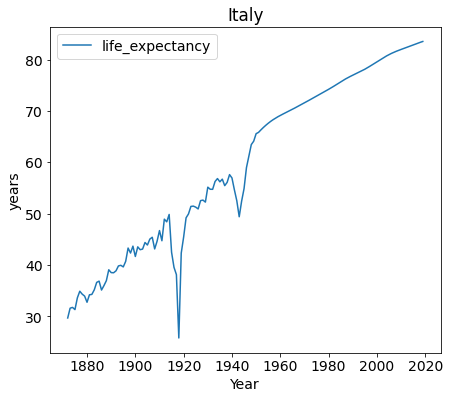

In [4]:
# make large plots
plt.rcParams['figure.figsize']=7,6
plt.rcParams['font.size']=14

# plot the data
data.plot('Year','life_expectancy')
plt.title('Italy')
plt.ylabel('years')

The plot suggests that a simple, while rough, description of the data evolution is a linear one (except around the two world wars). We can therefore try to fit a linear model to the data, looking for a minimization of the sum of the squares of the deviations (i.e. we adopt a "least squares" approach). The first step is writing a function that computes our goodness of fit as a function of the model parameters:

In [5]:
def GoF(m,q,x=(data['Year']-1872.),y=data['life_expectancy']):
    """
    Goodness of fit assuming a linear model y = m*x + q
    """
    
    model = m*x+q
    squares = (model-y)**2
    
    return np.sum(squares)

We can then set up a grid of parameters over which we want to compute the goodness of fit:

In [6]:
m_grid = np.linspace(0.1,2.,100)
q_grid = np.linspace(10.,50.,99)

G = np.zeros([len(m_grid),len(q_grid)]) # set up empty array to hold the GoF values computed over the grid

Let's compute the goodness of fit! (this may be optimized much more than this...think about it)

In [7]:
for i in range(len(m_grid)):
    for j in range(len(q_grid)):
        G[i,j]=GoF(m_grid[i],q_grid[j])

We can now see the shape of the goodness of fit in the parameter space:

Text(0, 0.5, 'm [years/Year]')

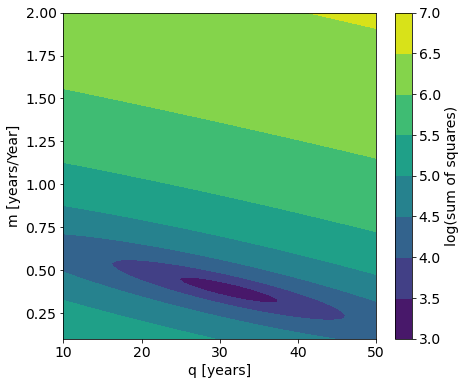

In [8]:
plt.contourf(q_grid,m_grid,np.log10(G))
plt.colorbar(label='log(sum of squares)')
plt.xlabel('q [years]')
plt.ylabel('m [years/Year]')

This quite clearly demonstrates where the minimum of the goodness of fit is located, and also gives visual information about the parameter degeneracies/correlations. We can find the position on the grid that corresponds to that minimum using the `argmin` function in `numpy`. It gives the index that corresponds to the point of minimum, but it first flattens the array: we must use the `unravel_index` function to reconstruct the actual point on the grid, as follows:

In [9]:
# find the index of the flattened G array that corresponds to its minimum
best_idx = np.argmin(G)
print('Index corresponding to the minimum of G (flattened): ',best_idx)

# "unravel" such index to reconstruct the i,j position of the minimum
i_best,j_best = np.unravel_index(best_idx,G.shape)
print('Matrix indices corresponding to the minimum of G: ',i_best,j_best)

# use these indices to find the best fitting parameters
m_best = m_grid[i_best]
q_best = q_grid[j_best]
print('Estimate of best-fitting parameters: m_best={0:.3f}, q_best={1:.2f}'.format(m_best,q_best))

Index corresponding to the minimum of G (flattened):  1536
Matrix indices corresponding to the minimum of G:  15 51
Estimate of best-fitting parameters: m_best=0.388, q_best=30.82


We can now plot the best-fitting model along with the data:

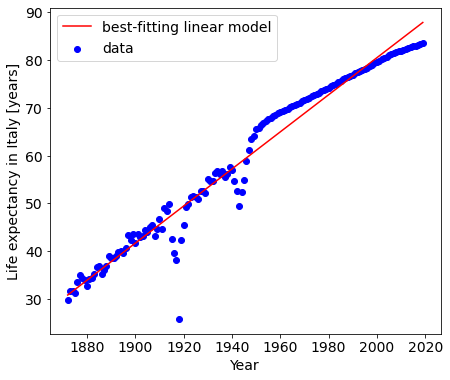

In [10]:
plt.scatter(data['Year'],data['life_expectancy'],color='b',label='data') # scatter plot with the original data
best_model = (data['Year']-1872.)*m_best + q_best # compute best-fitting model
plt.plot(data['Year'],best_model,'-r',label='best-fitting linear model') # plot the model
plt.xlabel('Year')
plt.ylabel('Life expectancy in Italy [years]')
plt.legend()


Based on this result, we can say that, on average, the life expectancy in Italy has risen by 3.9 years per decade since the late 1800's, starting from around 31 years in 1872. Clearly, the model does not describe fully the evolution: it does not fit the dips during the two world wars, and does not match the slower evolution from the sixties on. 

## Exercise 10

Fit the same data with a broken-linear model with a change of slope in 1960. Fix the initial life expectancy at 31 years (in 1872), to get a 2-parameter model. Would you also be able to perform a 3-parameter fit? (watch out: your GoF evaluation on the grid may get quite slow!)

## Using the `curve_fit` function in `scipy.optimize`

In some cases, especially when the number of parameters is larger than a few, or in automated cases, you may want to use a minimization algorithm to find the minimum of the goodness of fit statistic. You may also want to estimate the uncertainties on the parameter estimates by computing the derivatives of the statistic with respect to the parameters at the best fit point (the so-called "Fisher Matrix"). These complex tasks can be carried out in a simple way by relying on solid, tested third party libraries, such as `scipy`. The simplest function for this kind of application is `curve_fit` in the `optimize` sub-module. It implements a number of function minimization algorithms ([Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) for unconstrained problems, plus the [Trust Region Reflective](https://www.mathworks.com/help/optim/ug/least-squares-model-fitting-algorithms.html#broz0i4) or the [Dog Box](https://www.cs.uoi.gr/~lagaris/papers/PREPRINTS/dogbox.pdf) algorithms if parameter bounds are given) that are used to minimize the sum of the squared residuals (or the chi squared, if data uncertainties are provided). We can use it to fit a second-order polynomial to our data, as follows:

In [11]:
from scipy.optimize import curve_fit # note the "from x.y import z" statement

def model(x,a,b,c):
    """
    Second order polynomial a*x**2+b*x+c to be used with curve_fit.
    The first argument must be the independent variable, followed
    by the parameters, separated by commas.
    """
    return a*x**2+b*x+c

# initial guess (assume x=year-1872): we start from the linear solution we found earlier
a0 = 0. 
b0 = 0.4
c0 = 31.

# the simplest call to curve_fit only requires the model function & the x and y data
# and the starting guess p0=[a0,b0,c0]. This assumes the uncertainties are all the 
# same, and estimates the covariance matrix by imposing the reduced chi squared = 1 
# at the best fit
best_fit,cov_matrix = curve_fit(model,data['Year']-1872.,
                                data['life_expectancy'],
                                p0=[a0,b0,c0])

The `curve_fit` function outputs two numpy arrays: the first one is the array of best-fit parameter values; the second one is the covariance matrix (the inverse of the [Fisher Matrix](https://en.wikipedia.org/wiki/Fisher_information#Matrix_form)). Let's take a look at them:

In [12]:
print(best_fit)

[-4.81937248e-04  4.55548385e-01  2.94359493e+01]


In [13]:
print(cov_matrix)

[[ 2.60989724e-08 -3.83654897e-06  9.33560264e-05]
 [-3.83654897e-06  6.02077206e-04 -1.65240170e-02]
 [ 9.33560264e-05 -1.65240170e-02  6.09334810e-01]]


The squares of the diagonal elements of the covariance matrix give the estimated one-sigma uncertainties on the parameters, while the off-diagonal elements tell us about how the parameters are correlated. For example, we see that parameters `b` and `c` (which correspond to the `m` and `q` of our previous linear model) are negatively correlated, as before. Let's print the best-fit parameters with their uncertainties:

In [22]:
param_names = ['a','b','c']
for i in range(len(param_names)):
    print("{0} = {1:.3g} +/- {2:-3g}".format(param_names[i],
                                             best_fit[i],
                                             cov_matrix[i,i]**0.5))

a = -0.00123 +/- 8.62917e-05
b = 0.557 +/- 0.0151459
c = 28.4 +/- 0.654978


But what do these errors mean? We haven't specified the data uncertainties, so the procedure simply sets the best-fit reduced chi squared to 1, which is equivalent to assuming that the error uncertainties are equal to the sample variance of the residuals after the fit. We can get better results by specifying a data error, based on an educated guess. By looking at the data oscillations before the 1960's, we can see that there's at least a 2-year uncertainty on the data there, while data post-1960 seem based on more solid estimates (based on wider samples). We can construct our data uncertainty array as follows:

In [25]:
sigma = np.ones_like(data['Year']) # one-year uncertainty post-1960
sigma[data['Year']<1960.]=3. # three-year uncertainty beforehand

We may also want to give a large uncertainty to the time around the two World Wars, since these represent clear deviations from the general trend:

In [26]:
WWI = (data['Year']>=1915.) & (data['Year']<=1919.)
WWII = (data['Year']>=1939.) & (data['Year']<=1946.)
sigma[WWI] = 15.
sigma[WWII] = 10.

Let's repeat the fitting procedure now, and see how the result changes. We need to tell `curve_fit` not to set the reduced chi squared to 1 after the fit: we achieve this by setting `absolute_sigma=True`

In [27]:
best_fit,cov_matrix = curve_fit(model,data['Year']-1872.,
                                data['life_expectancy'],
                                p0=[a0,b0,c0],
                                sigma=sigma,
                                absolute_sigma=True)
param_names = ['a','b','c']
for i in range(len(param_names)):
    print("{0} = {1:.3g} +/- {2:-3g}".format(param_names[i],
                                             best_fit[i],
                                             cov_matrix[i,i]**0.5))

print('Covariance matrix:\n',cov_matrix)

a = -0.00123 +/- 8.62917e-05
b = 0.557 +/- 0.0151459
c = 28.4 +/- 0.654978
Covariance matrix:
 [[ 7.44626187e-09 -1.26381965e-06  4.23178523e-05]
 [-1.26381965e-06  2.29397116e-04 -8.79176750e-03]
 [ 4.23178523e-05 -8.79176750e-03  4.28995910e-01]]


The small error on `a` is due to the fact that the model is very sensitive to the value of this parameter (since the `x`'s take on large values). Since `a` and `b` are correlated, this also impacts the uncertainty on `b`. Let's see the best fitting model plotted over the data, along with the linear one we obtained before:

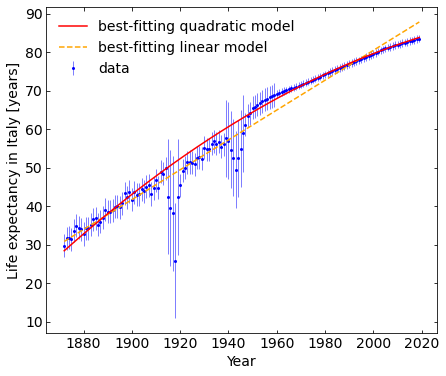

In [28]:
plt.errorbar(data['Year'],data['life_expectancy'],
             yerr=sigma,
             marker='o',
             markersize=2.,
             color='b',
             linestyle='None',
             zorder=1,
             elinewidth=0.5,
             label='data') # error bar plot with the original data

best_model = model(data['Year']-1872.,best_fit[0],best_fit[1],best_fit[2]) # compute best-fitting model
best_linear_model = (data['Year']-1872.)*m_best + q_best # compute best-fitting model
plt.plot(data['Year'],best_model,'-r',zorder=3,label='best-fitting quadratic model') # plot the model
plt.plot(data['Year'],best_linear_model,'--',zorder=2,color='orange',label='best-fitting linear model') # plot the linear model

plt.xlabel('Year')
plt.ylabel('Life expectancy in Italy [years]')

plt.tick_params(which='both',direction='in',top=True,right=True)

plt.legend(frameon=False)

We can now take a bold step and extrapolate our fit beyond the data: this should give a fair idea of how the life expectancy will change in the next few years (if no WWIII or other disasters take place!):

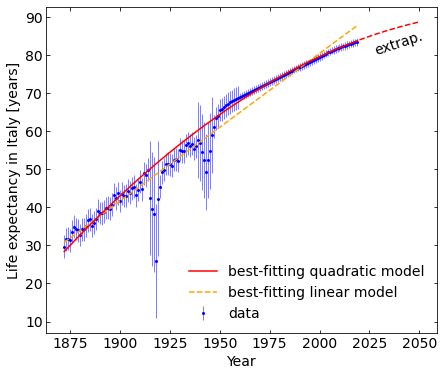

In [19]:
plt.errorbar(data['Year'],data['life_expectancy'],
             yerr=sigma,
             marker='o',
             markersize=2.,
             color='b',
             linestyle='None',
             zorder=1,
             elinewidth=0.5,
             label='data') # error bar plot with the original data

best_model = model(data['Year']-1872.,best_fit[0],best_fit[1],best_fit[2]) # compute best-fitting model
best_linear_model = (data['Year']-1872.)*m_best + q_best # compute best-fitting model
plt.plot(data['Year'],best_model,'-r',zorder=3,label='best-fitting quadratic model') # plot the model
plt.plot(data['Year'],best_linear_model,'--',zorder=2,color='orange',label='best-fitting linear model') # plot the linear model

y = np.linspace(2020,2050,10)
le = model(y-1872.,best_fit[0],best_fit[1],best_fit[2]) # extrapolate the best-fitting model
plt.plot(y,le,'--r',zorder=2)
plt.annotate('extrap.',xy=(2027,80),rotation=18)

plt.xlabel('Year')
plt.ylabel('Life expectancy in Italy [years]')

plt.tick_params(which='both',direction='in',top=True,right=True)

plt.legend(frameon=False)

## Exercise 11

What is the uncertainty on the extrapolated life expectancy in 2050, if you only consider the statistical errors on the fit parmeters? In order to find this out, we need to see how the uncertainties on the parameters propagate to the extrapolated value. The best way to do this is by a Monte Carlo method: we extract samples from the probability distribution in parameter space and compute the extrapolated value for each. We can then plot the resulting distribution of extrapolated values and measure its variance. Our Fisher Matrix estimate of the parameter uncertainties implies the assumption that the probability distribution of the parameters is a multivariate normal distribution: in order to draw samples from it, we can follow [this nice method](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution). The Cholesky decomposition of the covariance matrix can be obtained in a straightforward manner by using the `np.linalg.cholesky` function from `numpy`, and independent normally distributed samples can be obtained by the `np.random.normal` function.

Text(0, 0.5, 'probability density')

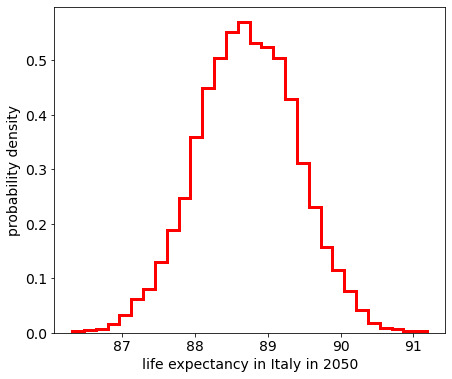

In [20]:
# compute the Cholesky decomposition of the cov. matrix
A = np.linalg.cholesky(cov_matrix)

# produce a lot of 3D normally-distributed samples
z = np.random.normal(0.,1.,[3,10000])

# use the affine transform to get the parameter samples
xi = best_fit + A.dot(z).T

# compute the extrapolated life expectancy
le2050 = np.zeros(z.shape[1])
for i in range(len(le2050)):
    le2050[i] = model(2050.-1872.,xi[i,0],xi[i,1],xi[i,2])

# plot a histogram of the resulting samples
plt.hist(le2050,bins=30,histtype='step',lw=3,color='red',density=True)
plt.xlabel('life expectancy in Italy in 2050')
plt.ylabel('probability density')

The result can be summarized by printing the mean and standard deviation of the samples:

In [21]:
print('Extrapolated life expectancy in Italy in 2050: {0:.1f} +/- {1:.1f} years'.format(
    np.mean(le2050),np.std(le2050)))

Extrapolated life expectancy in Italy in 2050: 88.7 +/- 0.7 years


## Final remark

Model fitting is like art, there is a plethora of different techniques, each of which needs to be mastered by both learning the theory behind and by practicing in a trial and error fashion. Often, your results will depend strongly on the setup of your algorithm, so do not just take the first answer without critical thinking! 

A particularly complex aspect is that of error estimation: the 